## Requiremnets
- pytorch
- python 3.11
- matplotlib
- numpy
- pandas
- pickle
- scikit-learn

In [ ]:
# To install pytorch if not already installed
pip install torchsummary

# pip can be used to install all other dependencies. 
# Incase someone has a different python version, please try
python_v -m pip install package 
# Here python_v should be replaced with your python version
# For example `python3.12 -m pip install torchsummary`

Note: you may need to restart the kernel to use updated packages.


# Code to run one variable at a time

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torch
import pickle

# Define paths and parameters
Data_path = './complete_data.csv'
temp_exclude_columns = ["0", "PPT ID", "Site", "BMD - Total", "Race", "% fat - Total", "Gender", "ALM"]
target_columns = ['BMD - Total', '% fat - Total', 'ALM']
rmsetarget = dict()

# Load the dataset
Data_set = pd.read_csv(Data_path)

class CSVDataset(Dataset):
    def __init__(self, features, targets):
        self.scaler = MinMaxScaler()
        self.features = self.scaler.fit_transform(features)
        self.targets = targets.values.reshape(-1, 1).astype('float32')

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

def prepare_data(df, exclude_columns, target_column):
    df = df.drop(columns=exclude_columns, axis=1)
    input_features = df.drop(columns=[target_column])
    target = df[target_column]
    df_dataset = CSVDataset(input_features, target)
    return df_dataset

def train_model(train_dl, model, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in train_dl:
            inputs, targets = batch['features'], batch['targets']
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_dl:
            inputs, targets = batch['features'], batch['targets']
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    max_err = max_error(actuals, predictions)
    return mse, mae, max_err, predictions, actuals

class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_inputs, 10)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.hidden2 = nn.Linear(10, 8)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.hidden3 = nn.Linear(8, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)

    def forward(self, X):
        X = torch.relu(self.hidden1(X))
        X = torch.relu(self.hidden2(X))
        X = self.hidden3(X)
        return X

def run_experiment(target_column):
    exclude_columns = temp_exclude_columns.copy()
    if target_column in exclude_columns:
        exclude_columns.remove(target_column)
    Data_set_dataset = prepare_data(Data_set, exclude_columns, target_column)
    percent_rmse_vs_epoch = dict()
    epochvsrmse = pd.DataFrame()

    batch_size = 16
    num_runs = 10
    k = 5

    best_rmse = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(50, 450, 50):
        Percentage_Rmses = np.zeros((num_runs, k))
        Percentage_mae = np.zeros((num_runs, k))
        Percentage_max = np.zeros((num_runs, k))

        for run in range(num_runs):
            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            for fold, (train_index, test_index) in enumerate(kf.split(np.arange(len(Data_set_dataset)))):
                train_subset = Subset(Data_set_dataset, train_index)
                test_subset = Subset(Data_set_dataset, test_index)

                train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
                test_dl = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

                first_batch = next(iter(train_dl))
                n_inputs = first_batch['features'].shape[1]

                model = MLP(n_inputs)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=0.01)

                train_model(train_dl, model, criterion, optimizer, epoch)
                mse, mae, max_err, predictions, actuals = evaluate_model(test_dl, model)
                rmse = np.sqrt(mse)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model_state = model.state_dict()
                    best_epoch = epoch
                
                mae = (mae / np.mean(actuals)) * 100
                average_actuals = np.sqrt(np.mean(np.square(actuals)))
                percent_rmse = (rmse / average_actuals) * 100
                Percentage_Rmses[run, fold] = percent_rmse
                Percentage_mae[run, fold] = mae
                Percentage_max[run, fold] = max_err

        mean_percentage_rmse = np.mean(Percentage_Rmses)
        mean_mae = np.mean(Percentage_mae)
        mean_max = np.mean(Percentage_max)

        epochvsrmse = pd.concat([epochvsrmse, pd.DataFrame([{"target": target_column, "Epoch": epoch, "RMSE": rmse,
                                                             "MeanPercentageRMSE": mean_percentage_rmse, "meanmae": mean_mae, "meanmax": mean_max}])],
                                ignore_index=True)

        percent_rmse_vs_epoch[epoch] = list(np.mean(Percentage_Rmses, axis=1))

    return epochvsrmse, percent_rmse_vs_epoch, best_model_state, best_epoch

if __name__ == "__main__":
    
    # List of dependet variables
    dependent_variables = ['BMD - Total', '% fat - Total', 'ALM']
    
    for target_column in dependent_variables:
        
        # Run training
        epochvsrmse, percent_rmse_vs_epoch, best_model_state, best_epoch = run_experiment(target_column)
        
        # Save rmse per epoch in CSV
        epochvsrmse.to_csv(f'epoch_vs_rmse_{target_column}.csv', index=False)
        
        # Save percent rmse per epoch per dependent variable 
        rmsetarget[target_column] = percent_rmse_vs_epoch
        
        # Save the rmse per epoch per dependent variable in a pickle file
        with open(f'rmse_target_{target_column}.pkl', 'wb') as f:
            pickle.dump(rmsetarget, f)

        # Save the best weights for testing for each dependent variable
        torch.save(best_model_state, f'best_model_{target_column}_epoch_{best_epoch}.pth')

# Code with parallel runs on all targets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torch
import pickle
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# Define paths and parameters
Data_path = './complete_data.csv'
temp_exclude_columns = ["0", "PPT ID", "Site", "BMD - Total", "Race", "% fat - Total", "Gender", "ALM"]
target_columns = ['BMD - Total', '% fat - Total', 'ALM']
rmsetarget = dict()

# Load the dataset
Data_set = pd.read_csv(Data_path)

class CSVDataset(Dataset):
    def __init__(self, features, targets):
        self.scaler = MinMaxScaler()
        self.features = self.scaler.fit_transform(features)
        self.targets = targets.values.reshape(-1, 1).astype('float32')

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

def prepare_data(df, exclude_columns, target_column):
    df = df.drop(columns=exclude_columns, axis=1)
    input_features = df.drop(columns=[target_column])
    target = df[target_column]
    df_dataset = CSVDataset(input_features, target)
    return df_dataset

def train_model(train_dl, model, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in train_dl:
            inputs, targets = batch['features'], batch['targets']
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_dl:
            inputs, targets = batch['features'], batch['targets']
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    max_err = max_error(actuals, predictions)
    return mse, mae, max_err, predictions, actuals

class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_inputs, 10)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.hidden2 = nn.Linear(10, 8)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.hidden3 = nn.Linear(8, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)

    def forward(self, X):
        X = torch.relu(self.hidden1(X))
        X = torch.relu(self.hidden2(X))
        X = self.hidden3(X)
        return X

def run_experiment(target_column):
    exclude_columns = temp_exclude_columns.copy()
    if target_column in exclude_columns:
        exclude_columns.remove(target_column)
    Data_set_dataset = prepare_data(Data_set, exclude_columns, target_column)
    percent_rmse_vs_epoch = dict()
    epochvsrmse = pd.DataFrame()

    batch_size = 16
    num_runs = 10
    k = 5

    best_rmse = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(50, 450, 50):
        Percentage_Rmses = np.zeros((num_runs, k))
        Percentage_mae = np.zeros((num_runs, k))
        Percentage_max = np.zeros((num_runs, k))

        for run in range(num_runs):
            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            for fold, (train_index, test_index) in enumerate(kf.split(np.arange(len(Data_set_dataset)))):
                train_subset = Subset(Data_set_dataset, train_index)
                test_subset = Subset(Data_set_dataset, test_index)

                train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
                test_dl = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

                first_batch = next(iter(train_dl))
                n_inputs = first_batch['features'].shape[1]

                model = MLP(n_inputs)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=0.01)

                train_model(train_dl, model, criterion, optimizer, epoch)
                mse, mae, max_err, predictions, actuals = evaluate_model(test_dl, model)
                rmse = np.sqrt(mse)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model_state = model.state_dict()
                    best_epoch = epoch
                
                mae = (mae / np.mean(actuals)) * 100
                average_actuals = np.sqrt(np.mean(np.square(actuals)))
                percent_rmse = (rmse / average_actuals) * 100
                Percentage_Rmses[run, fold] = percent_rmse
                Percentage_mae[run, fold] = mae
                Percentage_max[run, fold] = max_err

        mean_percentage_rmse = np.mean(Percentage_Rmses)
        mean_mae = np.mean(Percentage_mae)
        mean_max = np.mean(Percentage_max)

        epochvsrmse = pd.concat([epochvsrmse, pd.DataFrame([{"target": target_column, "Epoch": epoch, "RMSE": rmse,
                                                             "MeanPercentageRMSE": mean_percentage_rmse, "meanmae": mean_mae, "meanmax": mean_max}])],
                                ignore_index=True)

        percent_rmse_vs_epoch[epoch] = list(np.mean(Percentage_Rmses, axis=1))

    return epochvsrmse, percent_rmse_vs_epoch, best_model_state, best_epoch

def run_experiment_for_target(target_column):
    epochvsrmse, percent_rmse_vs_epoch, best_model_state, best_epoch = run_experiment(target_column)
    
    epochvsrmse.to_csv(f'epoch_vs_rmse_{target_column}.csv', index=False)
    rmsetarget[target_column] = percent_rmse_vs_epoch

    with open(f'rmse_target_{target_column}.pkl', 'wb') as f:
        pickle.dump(rmsetarget, f)

    torch.save(best_model_state, f'best_model_{target_column}_epoch_{best_epoch}.pth')
    return f'Finished {target_column}'

if __name__ == "__main__":
    target_columns = ['BMD - Total', '% fat - Total', 'ALM']

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(run_experiment_for_target, target) for target in target_columns]
        
        for future in concurrent.futures.as_completed(futures):
            print(future.result())


# Code for boxplots with different Y-axis limits

          50        100        150        200        250        300  \
0  14.296331  13.273204  13.280223  13.347998  12.806863  13.778143   
1  13.908329  13.625936  13.400715  13.767753  12.934903  12.944354   
2  13.790202  13.794723  13.079262  13.119329  13.050275  12.893710   
3  13.599914  13.687464  13.540824  13.639852  12.813560  12.796914   
4  14.382417  14.166661  13.369425  12.766608  12.813847  13.501188   

         350        400         target  
0  13.147352  13.111161  % fat - Total  
1  13.816325  12.311894  % fat - Total  
2  13.254479  13.129482  % fat - Total  
3  12.871309  13.307341  % fat - Total  
4  13.260226  13.342547  % fat - Total  


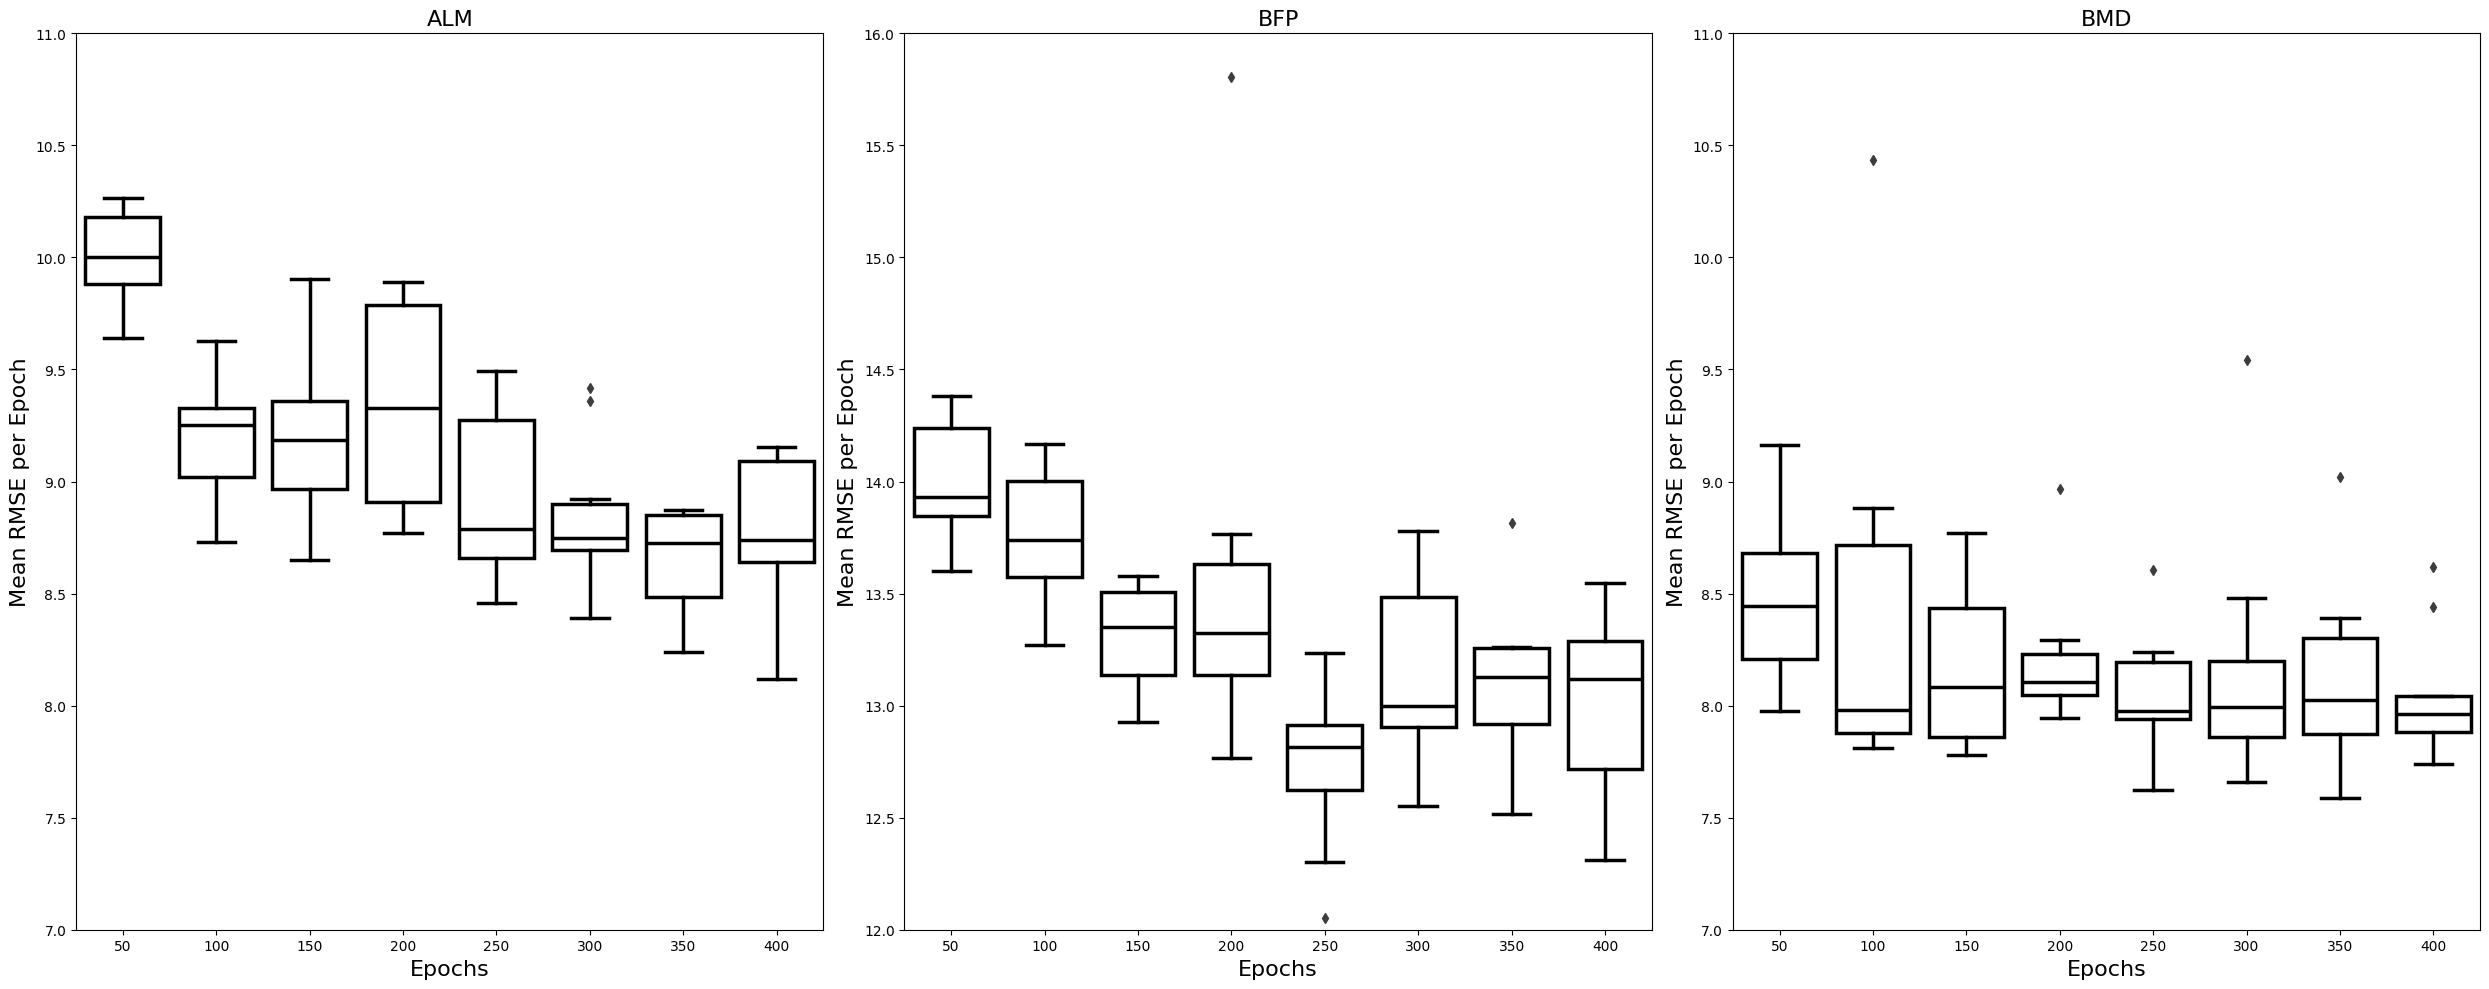

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rmsetarget is already defined and populated
data = pd.DataFrame()
targets = ['rmse_target_% fat - Total.pkl', 'rmse_target_ALM.pkl', 'rmse_target_BMD - Total.pkl']
rmsetarget = dict()
for target in targets:
    rmsetarget.update(pd.read_pickle(f'./{target}'))


for key, value in rmsetarget.items():
    df = pd.DataFrame(value)
    df["target"] = key
    data = pd.concat([data, df], ignore_index=True)

print(data.head())

# Plotting
plt.figure(figsize=(25, 10))
targets = ['ALM', '% fat - Total', 'BMD - Total']
ylims = [(7, 11), (12, 16), (7, 11)]  # Different y-limits for each target

for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=data[data['target'] == target].drop('target', axis=1), 
                showmeans=False,
                sym='+', whis=1.5,
                boxprops=dict(facecolor="None", edgecolor="black", linewidth=2.5),
                #meanprops=dict(marker='p', markerfacecolor='black', markeredgecolor='black', markersize=6),
                whiskerprops=dict(color="black", linewidth=2.5),
                capprops=dict(color="black", linewidth=2.5),
                medianprops=dict(color="black", linewidth=2.5),
                showfliers=True)  # Remove outliers
    
    if target=='% fat - Total':
        plt.title(f"BFP", fontsize=16)
    elif target=='BMD - Total':
        plt.title(f"BMD", fontsize=16)
    else:
        plt.title(f"ALM", fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean RMSE per Epoch', fontsize=16)
    plt.ylim(ylims[i])
    plt.grid(False)

plt.tight_layout()
plt.savefig("BoxplotsEpochvsMeanRMSEmaleData.png", dpi=300)
plt.show()
